In [1]:
import torch
import numpy
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio 
import io

In [2]:
#0, position, min = -1.2, max = 0.6
#1, velocity, min = -0.07, max = 0.07

In [39]:
#state = position, velocity
def get_mountain_car_data(force=0.002,gravity=0.0025):
    #no actions
    data = []
    position_linspace = np.arange(-1.2, 0.6, 0.01)
    velocity_linspace = np.arange(-0.07, 0.07, 0.01)
    for position in position_linspace:
        for velocity in velocity_linspace:
            state = torch.tensor([position, velocity],dtype=torch.float32)
            next_velocity =  velocity + -1*force - np.cos(3*position)*gravity
            next_position = position + next_velocity
            next_state = torch.tensor([next_position, next_velocity],dtype=torch.float32)
            data.append((state, next_state))
    return data

In [40]:
class LQR(nn.Module):
    def __init__(self, enc_dim,in_dim):
        super(LQR, self).__init__()
        self.A = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))
       
        self.state_encoder = torch.nn.Sequential(
            torch.nn.Linear(in_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, enc_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim, enc_dim),
        )

        self.state_decoder = torch.nn.Sequential(
            torch.nn.Linear(enc_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, in_dim)
        )
    def forward (self,x):
        xx = self.state_encoder(x)
        #xx = xx.squeeze(0)
        x_prime_prediction = self.A @ xx 
        return self.state_decoder(x_prime_prediction), x_prime_prediction, xx, #reward.unsqueeze(0)

In [41]:
def train_model(model,optimizer,train_data_loader,epochs=1):
    criterion = torch.nn.MSELoss()
    for i in range(epochs):
        total_state_loss = 0
        total_reward_loss = 0
        for x, y in train_data_loader:
            x = x.squeeze(0)
            y = y.squeeze(0)
            optimizer.zero_grad()
            lqr_x_prime, x_prime_expanded, xx = model(x)
            #reward_loss = criterion(reward, r)
            lqr_pred_loss = criterion(lqr_x_prime, y)
            decoder_loss = criterion(model.state_decoder(xx), x)
            encoder_loss = criterion(model.state_encoder(y), x_prime_expanded) 
            state_loss = lqr_pred_loss  + decoder_loss + encoder_loss
            loss = state_loss #+ reward_loss
            loss.backward()
            optimizer.step()
            total_state_loss += state_loss.item()
            total_reward_loss += 0#reward_loss.item()
        print("Epoch: ", i, "State Loss: ", total_state_loss/len(train_data_loader))

In [42]:
train_data_loader = torch.utils.data.DataLoader(get_mountain_car_data(), batch_size=1, shuffle=True)

In [43]:
model = LQR(128,2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
train_model(model,optimizer,train_data_loader,epochs=10)

Epoch:  0 State Loss:  0.017164199020222037
Epoch:  1 State Loss:  0.003617748553057296
Epoch:  2 State Loss:  0.0016122841131369502
Epoch:  3 State Loss:  0.0015698338020000073
Epoch:  4 State Loss:  0.001184908861685943
Epoch:  5 State Loss:  0.0009502754274917943
Epoch:  6 State Loss:  0.000969031403087515
Epoch:  7 State Loss:  0.0009142759236448439
Epoch:  8 State Loss:  0.0006756630131694356
Epoch:  9 State Loss:  0.0006872160608219457


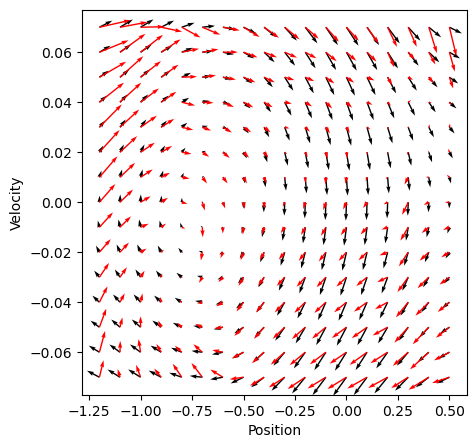

In [45]:
def plot_policy(model,ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    positions = np.arange(-1.2, 0.6, .1)
    velocities = np.arange(-0.07, 0.07, .01)
    X, V = np.meshgrid(positions, velocities)
    NX = np.zeros_like(X)
    NV = np.zeros_like(V)

    NX_model = np.zeros_like(X)
    NV_model = np.zeros_like(V)
    for i, x in enumerate(positions):
        for j, v in enumerate(velocities):
            #actions = np.array([policy.action_sample((x, v)) for _ in range(50)])
            actions = 0
            nv = v + .001*(actions - 1) - .0025*np.cos(3*x) #changed action to 0
            nx = x + nv

            next,_,_ = model(torch.tensor([x, v],dtype=torch.float32)) #new addition
            nx_model, nv_model = next
            NX_model[j, i] = nx_model.mean()
            NV_model[j, i] = nv_model
            NX[j, i] = nx.mean()
            NV[j, i] = nv.mean()
    DX = NX - X
    DV = NV - V
    DX_model = NX_model - X
    DV_model = NV_model - V

    q = ax.quiver(X, V, DX/(DX.max() - DX.min()), DV/(DV.max() - DV.min()))
    q_model = ax.quiver(X, V, DX_model/(DX_model.max() - DX_model.min()), DV_model/(DV_model.max() - DV_model.min()), color='red')
    ax.set_box_aspect(1)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')

plot_policy(model)